In [1]:
import gym
import torch
import gym_nav
import numpy as np

import sys
sys.path.append('../')
from evaluation import *
from model_evaluation import *
from trajectories import *
from shortcut_analysis import *
from explore_analysis import *
from plotting_utils import *

from tqdm import tqdm
from umap import UMAP

pplt.rc.reset()

# Hallucination Experiment

Idea is to measure how sensitive to hallucinated visual input agent is. At the start of the episode, append a few observations of shortcut being open or closed. How many steps before behavior is affected?



In [2]:
chk = 460
t = 5
p = 0.4

model, obs_rms = load_chk(f'shortcut_wc1.5p{p}', chk=chk, subdir='shortcut_wc2', trial=t)

In [18]:
env_kw = {'wall_colors': 1.5, 'shortcut_probability': 1, 
        'character_reset_pos': 3, 'fixed_reset': [np.array([150., 20.]), np.pi/2]}
res = evaluate(model, obs_rms, env_name='ShortcutNav-v0', env_kwargs=env_kw, with_activations=True,
        data_callback=shortcut_visdata_callback, num_episodes=1, deterministic=True, seed=1)


In [212]:
class HallucinationActivator(object):
    def __init__(self, hallucination_check=lambda: None,
                 hallucinations=lambda: None):
        '''Generate a hallucination object to pass to a hallucination_evaluate call
        
        hallucination_check: a function that takes t, h_t, currently_hallucinating, env, data 
            t: elapsed environment steps
            h_t: number of hallucinated steps
            currently_hallucinating: used for continuous hallucinations
            env: the current environment
            data: the data dict from data_callback
        halllucinations: a function that takes current number of hallucinated timesteps and returns an 
            observation to give the agent 
        '''
        self.hallucinated_steps = 0
        self.hallucination_check = hallucination_check
        self.hallucinations = hallucinations
        self.currently_hallucinating = False
    
    def check_for_hallucination(self, t, env, data):
        if self.hallucination_check(t, self.hallucinated_steps, self.currently_hallucinating, env, data):
            self.currently_hallucinating = True
            return True
        else:
            self.currently_hallucinating = False
            return False
        
    def get_hallucination(self):
        obs = self.hallucinations(self.hallucinated_steps)
        self.hallucinated_steps += 1
        return obs
    
    def reset(self):
        self.hallucinated_steps = 0
        self.halucinating = False
        
        
    

def shortcut_sighting_hallu_check(t, h_t, hallucinating, env, data, n=5):
    '''
    Give a hallucination on the first time step the shortcut is sighted
    n: how long to hallucinate for'''
    if 'ep_shortcut_vis' in data and np.array(data['ep_shortcut_vis']).any() and h_t == 0:
        # first sighting, initiate hallucination
        return True
    elif hallucinating and h_t < n:
        return True
    
    return False

def periodic_closed_hallu(t, h_t, hallucinating, env, data, n=5):
    '''
    Give a hallucination on the first time step the shortcut is sighted
    n: how long to hallucinate for'''
    if t % n == 0:
        return True
    return False


env_kw = {'wall_colors': 1.5, 'shortcut_probability': 0, 
        'character_reset_pos': 3, 'fixed_reset': [np.array([150., 20.]), np.pi/2]}
env = gym.make('ShortcutNav-v0', **env_kw)
obs = env.reset()

def shortcut_sighting_hallu(h_t):
    return obs

hallucinator = HallucinationActivator(partial(shortcut_sighting_hallu_check, n=3), shortcut_sighting_hallu)
# hallucinator = HallucinationActivator(partial(periodic_closed_hallu, n=3), shortcut_sighting_hallu)

(None, SubplotGrid(nrows=1, ncols=1, length=1))

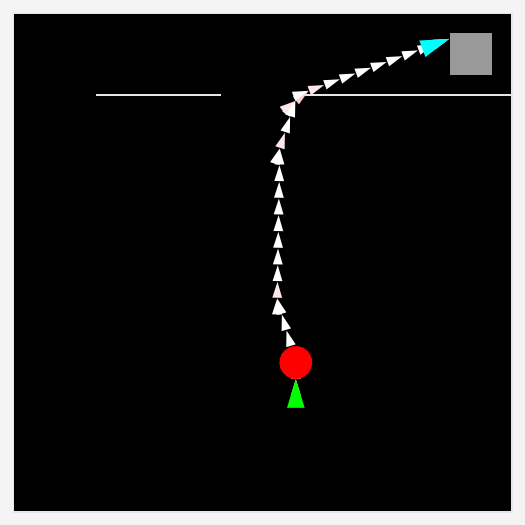

In [213]:
chk = 400
t = 5
p = 0.4

model, obs_rms = load_chk(f'shortcut_wc1.5p{p}', chk=chk, subdir='shortcut_wc2', trial=t)

# env_kw = {'wall_colors': 1.5, 'shortcut_probability': 1, 
#         'character_reset_pos': 3, 'fixed_reset': [np.array([170., 80.]), np.pi/2]}

# env_kw = {'wall_colors': 1.5, 'shortcut_probability': 1, 
#         'character_reset_pos': 3, 'fixed_reset': [np.array([140., 100.]), 4*np.pi/7]}

env_kw = {'wall_colors': 1.5, 'shortcut_probability': 1, 
        'character_reset_pos': 3}

res1 = hallucination_evaluate(model, obs_rms, env_name='ShortcutNav-v0', env_kwargs=env_kw, with_activations=True,
        data_callback=shortcut_visdata_callback, num_episodes=50, deterministic=True, seed=1)
res2 = hallucination_evaluate(model, obs_rms, env_name='ShortcutNav-v0', env_kwargs=env_kw, with_activations=True,
        data_callback=shortcut_visdata_callback, num_episodes=50, deterministic=True, seed=1, hallucinator=hallucinator)

pos = res['data']['pos']
angle = res['data']['angle']
shortcut_avail = res['data']['shortcut']

ep = 0
p = pos[ep]
a = angle[ep]
avail = shortcut_avail[ep][0]

set_trajectory_plot_style()

fig, ax = pplt.subplots()
draw_shortcut_maze(avail, ax=ax)
draw_trajectory(p, a, ax=ax)

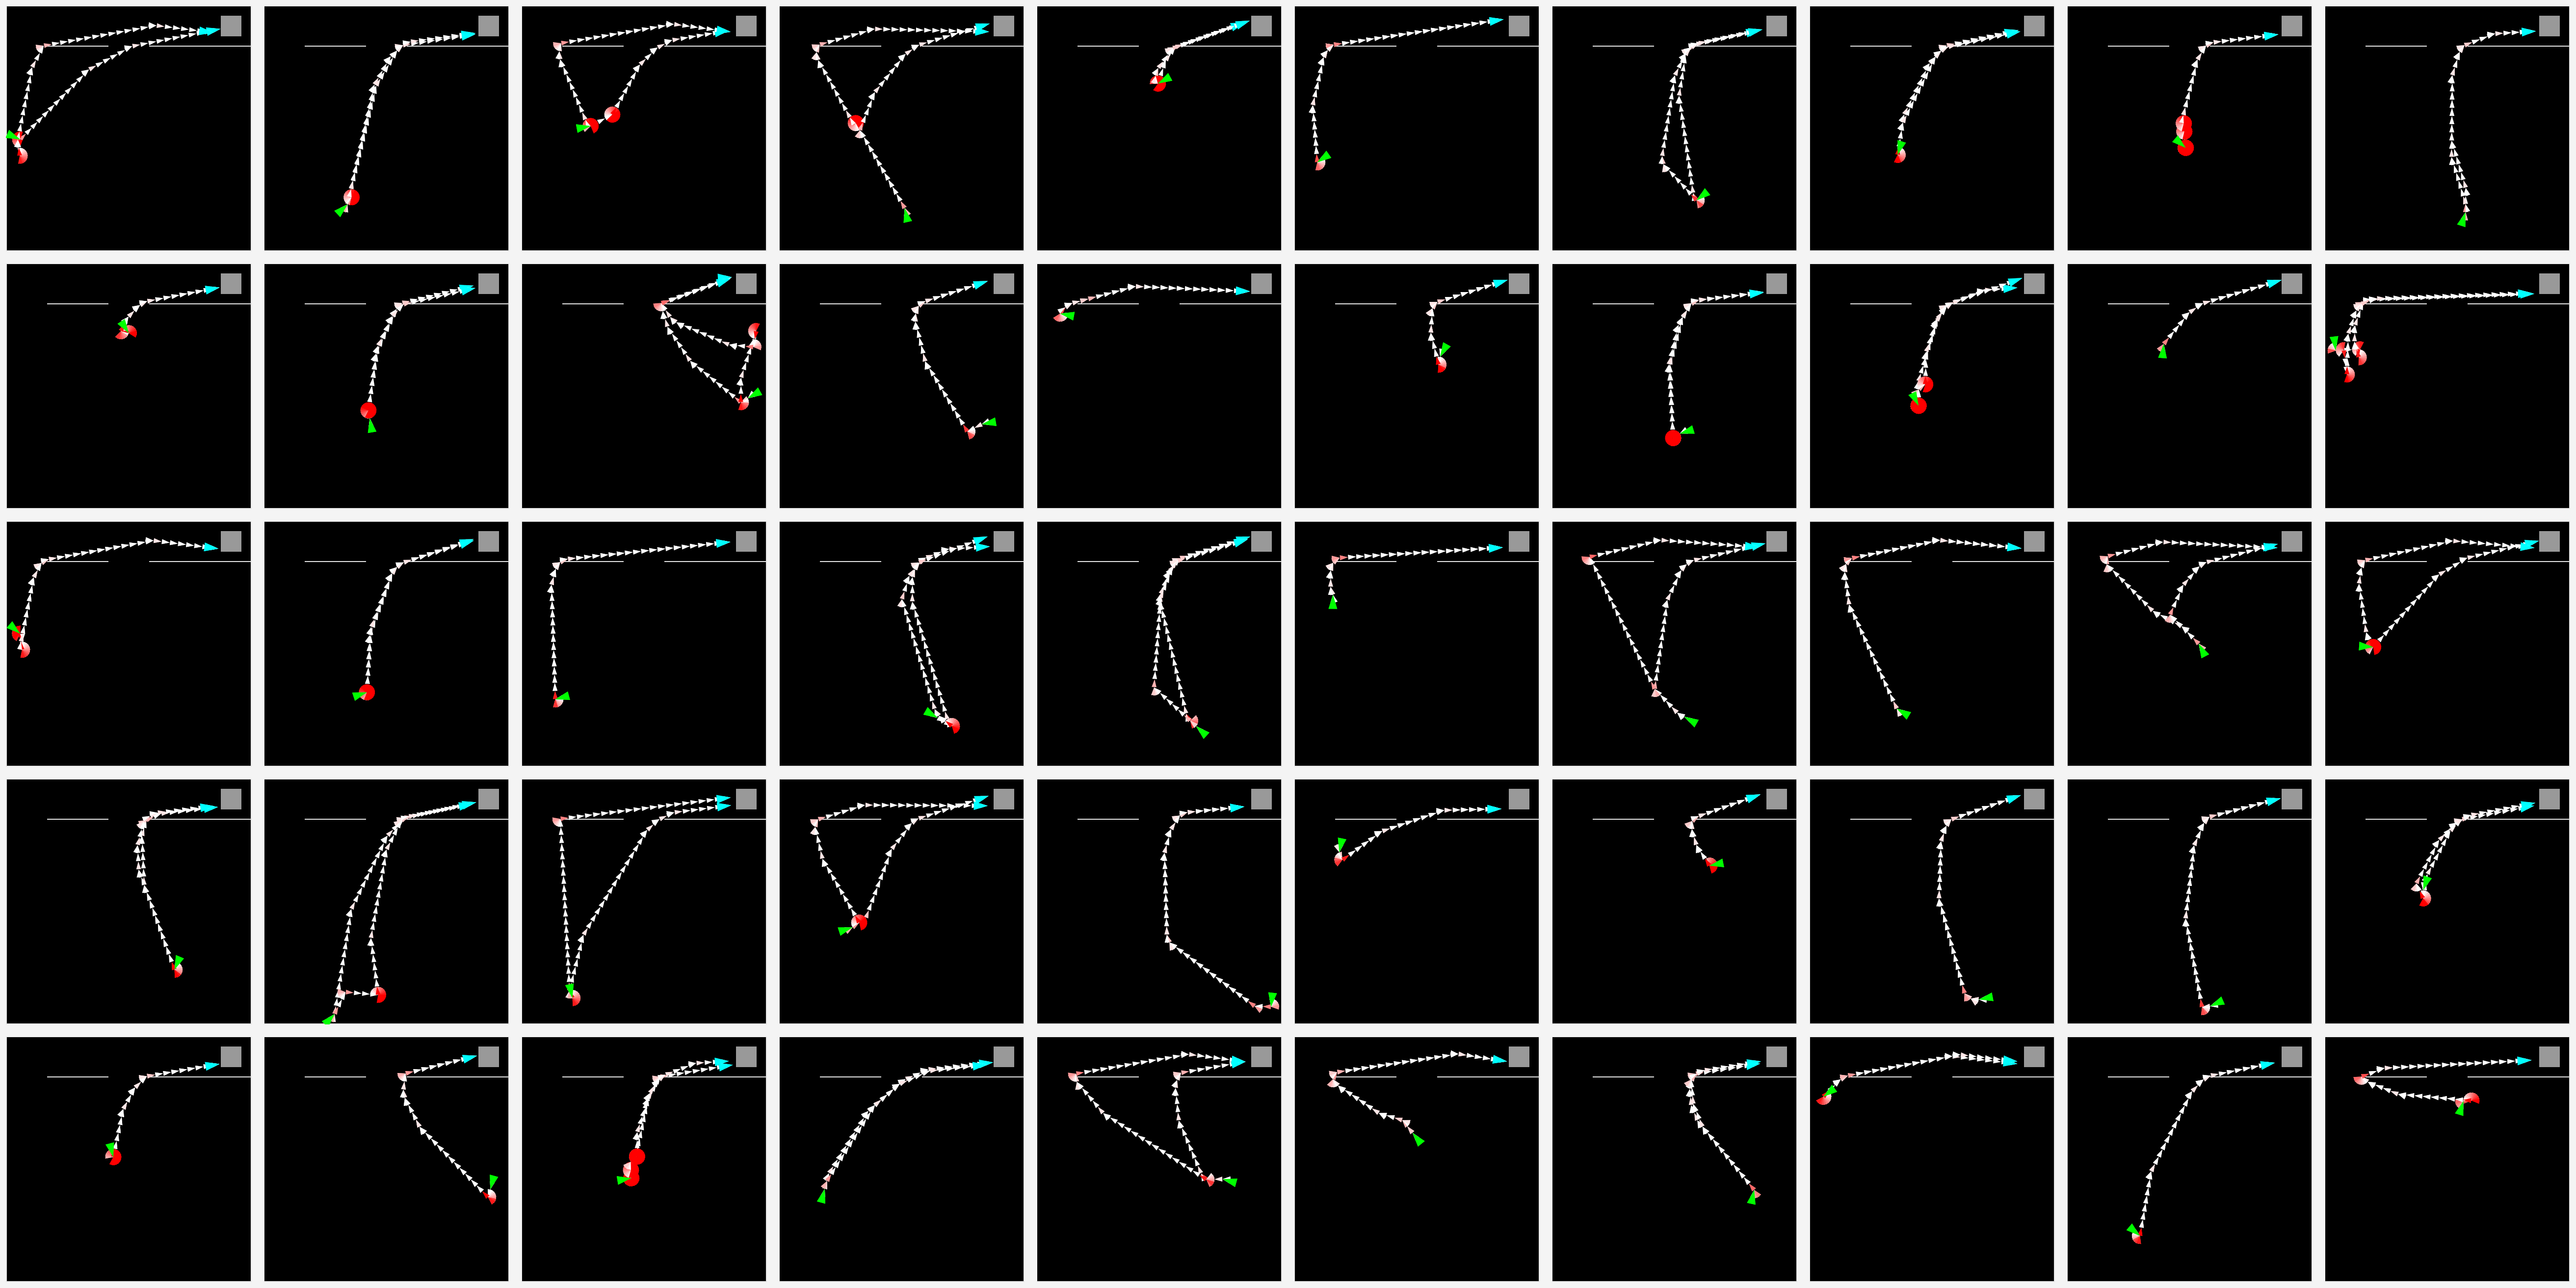

In [219]:
ep = 0
p = pos[ep]
a = angle[ep]
avail = shortcut_avail[ep][0]

set_trajectory_plot_style()

fig, ax = pplt.subplots(nrows=5, ncols=10)

for ep in range(50):
    draw_shortcut_maze(True, ax=ax[ep])
    
    p = res1['data']['pos'][ep]
    a = res1['data']['angle'][ep]
    draw_trajectory(p, a, ax=ax[ep])
    
    p = res2['data']['pos'][ep]
    a = res2['data']['angle'][ep]
    draw_trajectory(p, a, ax=ax[ep])


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [11:35<00:00, 69.54s/it]


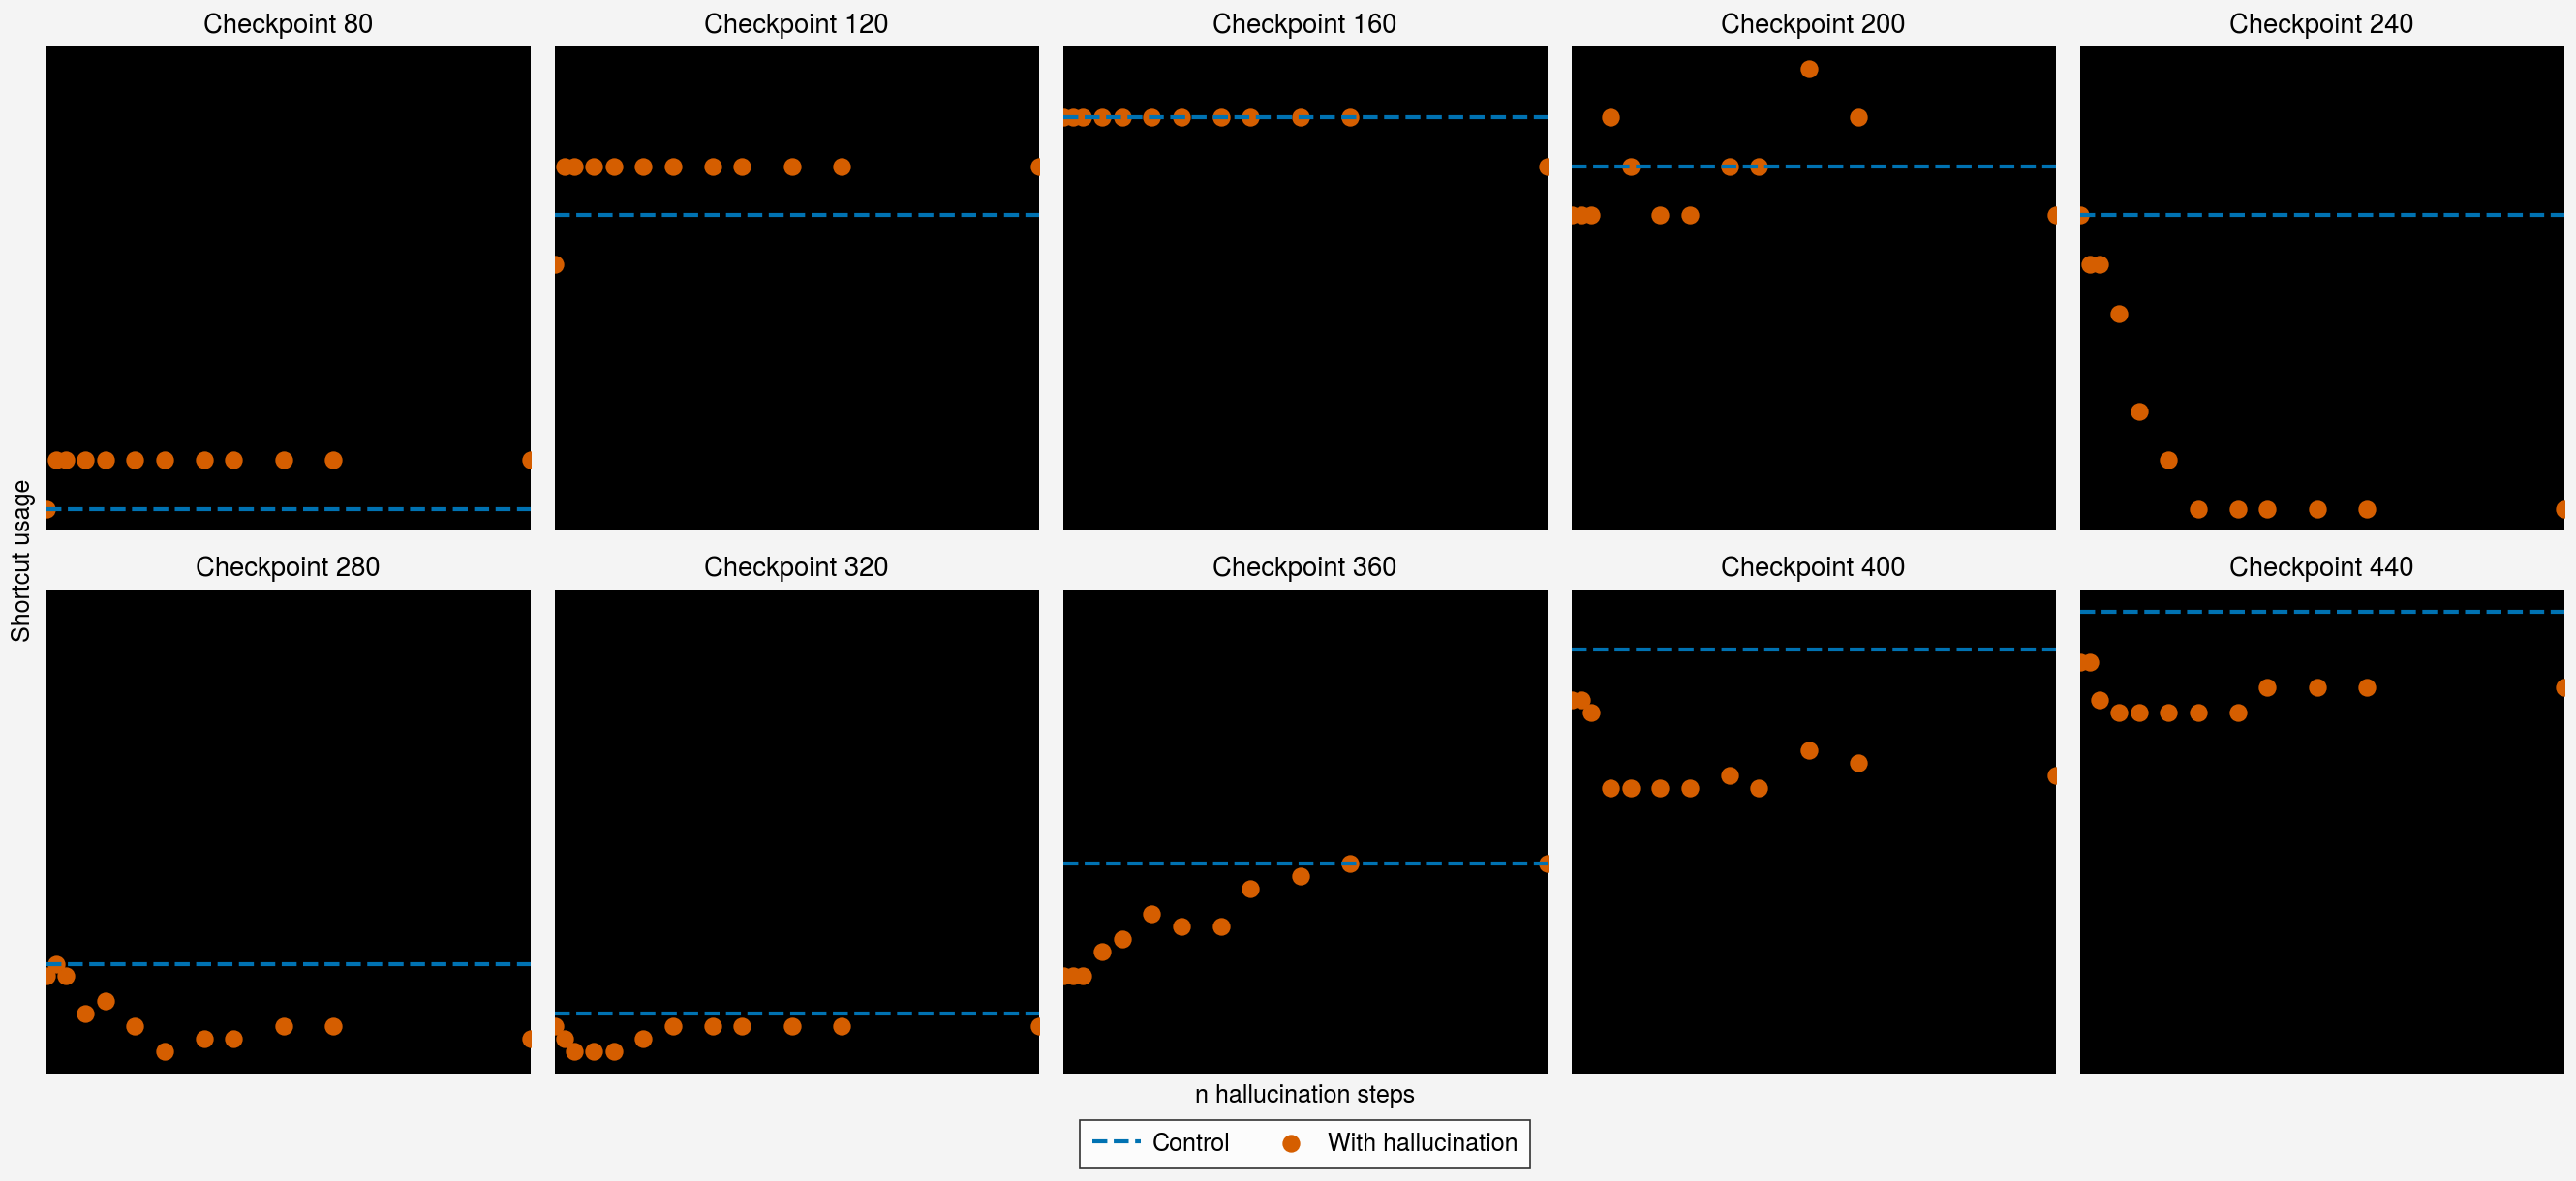

In [227]:
ns = [1, 2, 3, 5, 7, 10, 13, 17, 20, 25, 30, 50] # how many steps to hallucinate
chks = np.arange(80, 480, 40)

chk = 400
t = 5
p = 0.4

env_kw = {'wall_colors': 1.5, 'shortcut_probability': 1, 
        'character_reset_pos': 3}

fig, ax = pplt.subplots(ncols=5, nrows=2)

control_shortcut_usages = []
chk_n_uses = []
for i, chk in enumerate(tqdm(chks)):
    model, obs_rms = load_chk(f'shortcut_wc1.5p{p}', chk=chk, subdir='shortcut_wc2', trial=t)
    res1 = hallucination_evaluate(model, obs_rms, env_name='ShortcutNav-v0', env_kwargs=env_kw, with_activations=True,
            data_callback=shortcut_visdata_callback, num_episodes=50, deterministic=True, seed=1)
    use = np.sum([check_shortcut_usage(p) for p in res1['data']['pos']])
    control_shortcut_usages.append(use)
    
    n_uses = []
    
    for n in ns:
        hallucinator = HallucinationActivator(partial(shortcut_sighting_hallu_check, n=n), shortcut_sighting_hallu)
        res = hallucination_evaluate(model, obs_rms, env_name='ShortcutNav-v0', env_kwargs=env_kw, with_activations=True,
            data_callback=shortcut_visdata_callback, num_episodes=50, deterministic=True, seed=1, hallucinator=hallucinator)
        use = np.sum([check_shortcut_usage(p) for p in res['data']['pos']])
        n_uses.append(use)
    chk_n_uses.append(n_uses)
    
    ax[i].plot([1, 50], [control_shortcut_usages[i], control_shortcut_usages[i]], '--', label='Control')
    ax[i].scatter(ns, n_uses, label='With hallucination')
    
ax.format(title=[f'Checkpoint {chk}' for chk in chks], xlabel='n hallucination steps',
         ylabel='Shortcut usage')
ax[7].legend(loc='b')
    

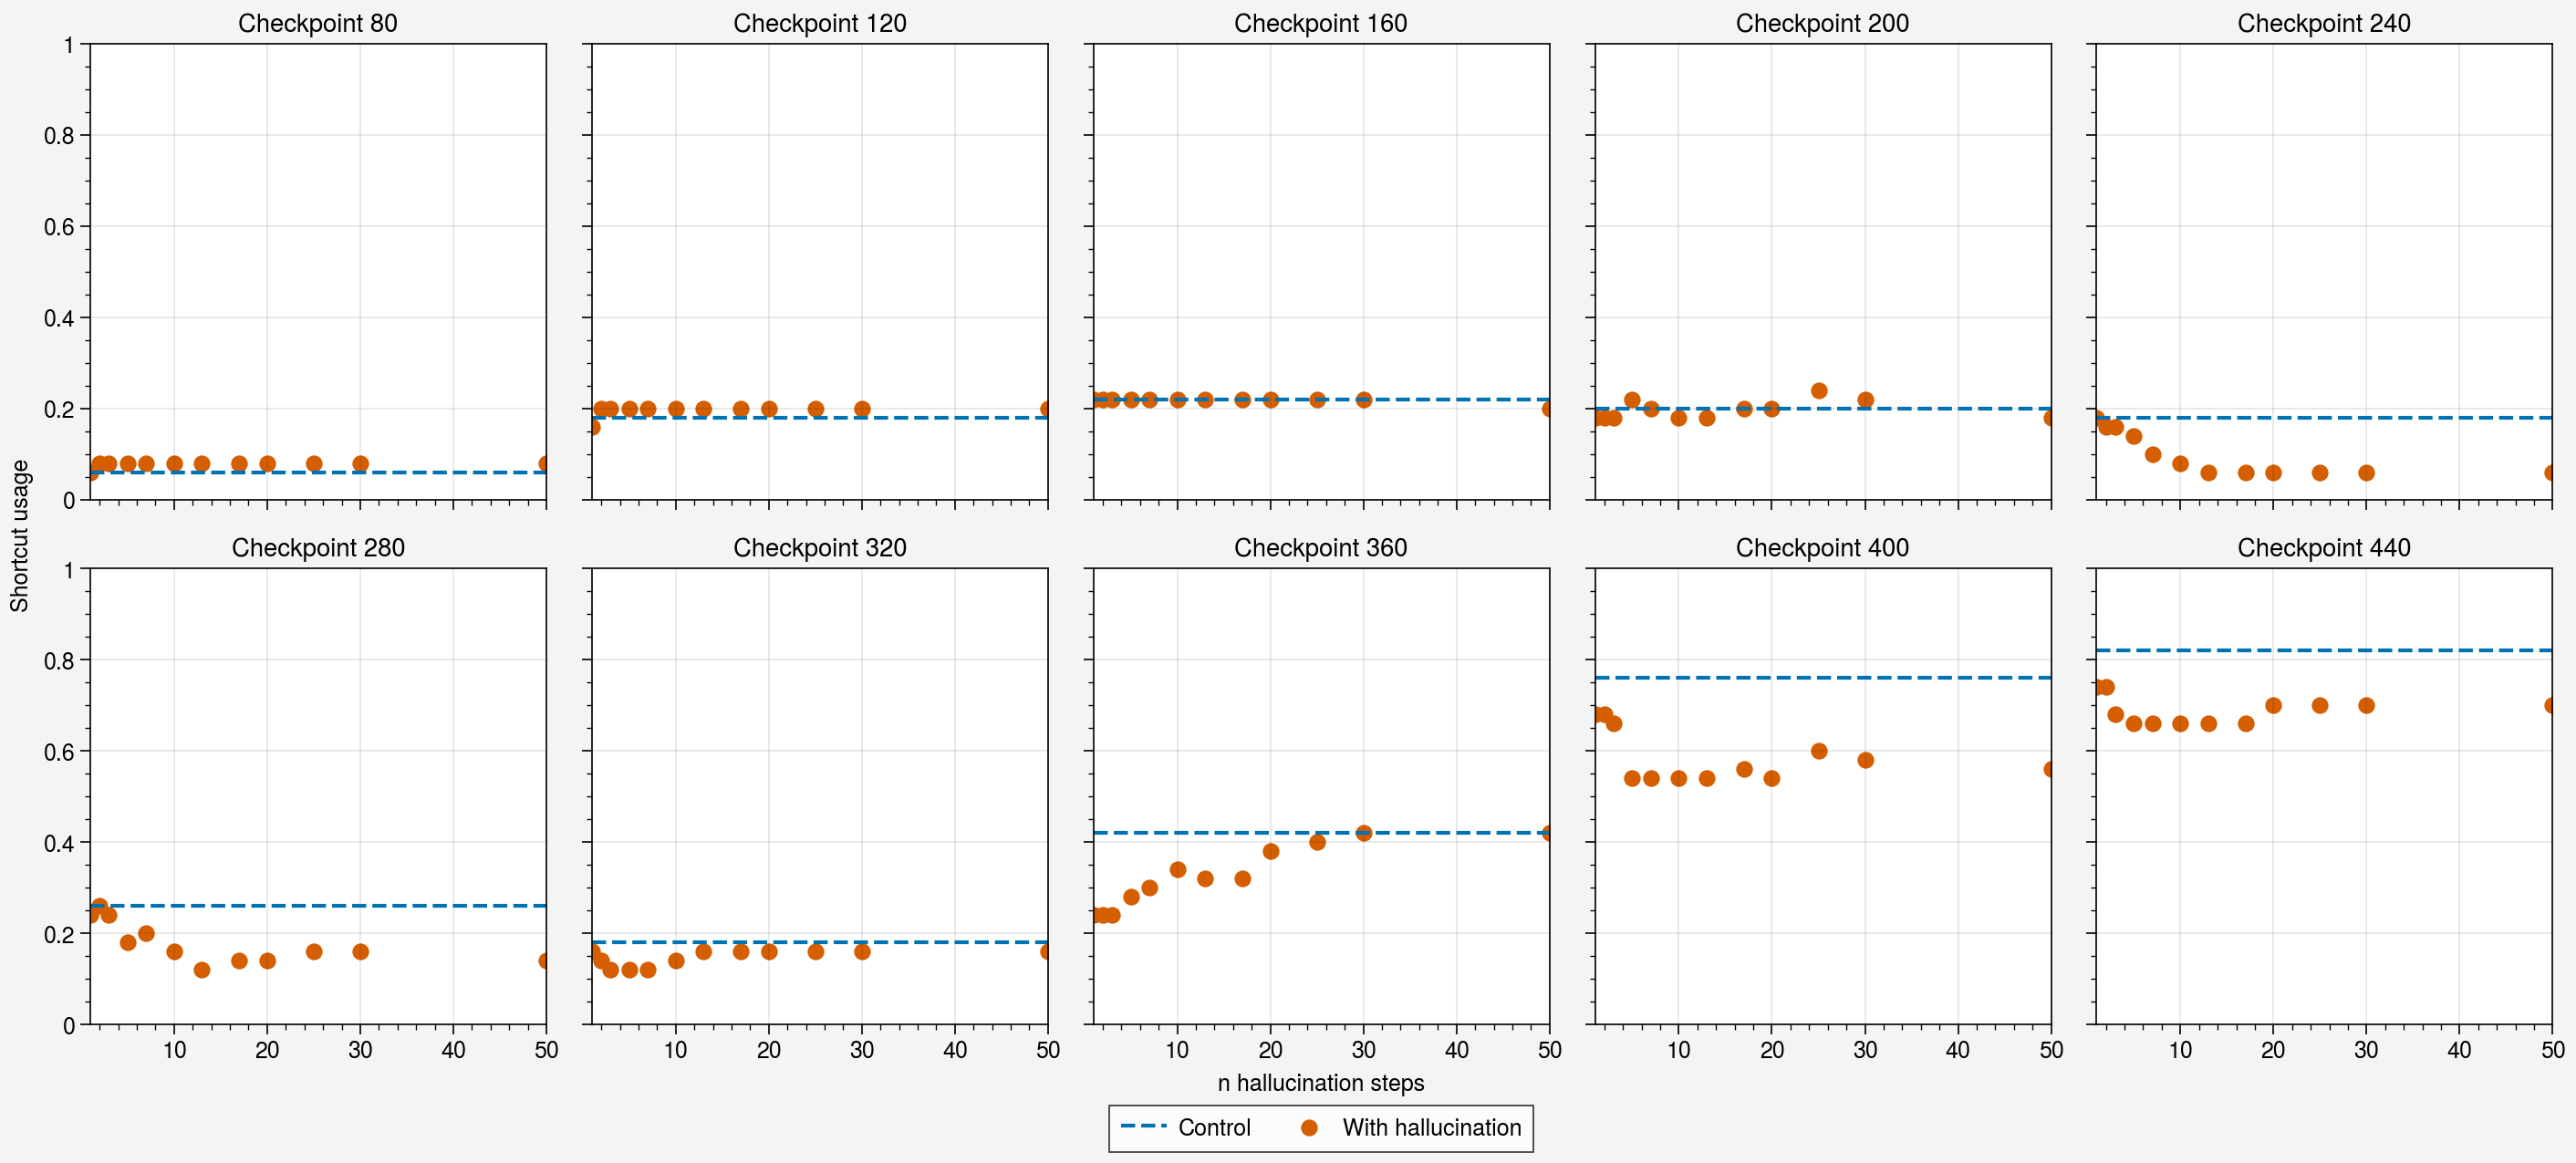

In [230]:

fig, ax = pplt.subplots(ncols=5, nrows=2)
for i, chk in enumerate(chks):
    ax[i].plot([1, 50], [control_shortcut_usages[i]/50, control_shortcut_usages[i]/50], '--', label='Control')
    ax[i].scatter(ns, np.array(chk_n_uses[i])/50, label='With hallucination')
    
ax.format(title=[f'Checkpoint {chk}' for chk in chks], xlabel='n hallucination steps',
         ylabel='Shortcut usage', ylim=[0, 1])
ax[7].legend(loc='b')


In [232]:
ns = [1, 3, 5, 10, 20, 30, 50] # how many steps to hallucinate
chks = np.arange(40, 480, 40)
probs = [0.1, 0.4]
trials = range(10)

env_kw = {'wall_colors': 1.5, 'shortcut_probability': 1, 
        'character_reset_pos': 3}

all_res = {'ns': ns}

control_shortcut_usages = []
chk_n_uses = []

for p, t in tqdm(itertools.product(probs, trials), total=2*10):
    key = f'{p}_{t}'
    all_res[key] = {'control_uses': [],
                    'chk_n_uses': []}
    for chk in chks:
        model, obs_rms = load_chk(f'shortcut_wc1.5p{p}', chk=chk, subdir='shortcut_wc2', trial=t)
        res1 = hallucination_evaluate(model, obs_rms, env_name='ShortcutNav-v0', env_kwargs=env_kw, with_activations=True,
                data_callback=shortcut_visdata_callback, num_episodes=50, deterministic=True, seed=1)
        use = np.sum([check_shortcut_usage(p) for p in res1['data']['pos']])
        all_res[key]['control_uses'].append(use)

        n_uses = []

        for n in ns:
            hallucinator = HallucinationActivator(partial(shortcut_sighting_hallu_check, n=n), shortcut_sighting_hallu)
            res = hallucination_evaluate(model, obs_rms, env_name='ShortcutNav-v0', env_kwargs=env_kw, with_activations=True,
                data_callback=shortcut_visdata_callback, num_episodes=50, deterministic=True, seed=1, hallucinator=hallucinator)
            use = np.sum([check_shortcut_usage(p) for p in res['data']['pos']])
            n_uses.append(use)
        all_res[key]['chk_n_uses'].append(n_uses)
        
    pickle.dump(all_res, open('data/shortcut/wc1.5_policy_moreagents/hallucination_shortcut_use', 'wb'))

    


100%|█████████████████████████████████████████████████████████████████████████████| 20/20 [13:17:28<00:00, 2392.44s/it]


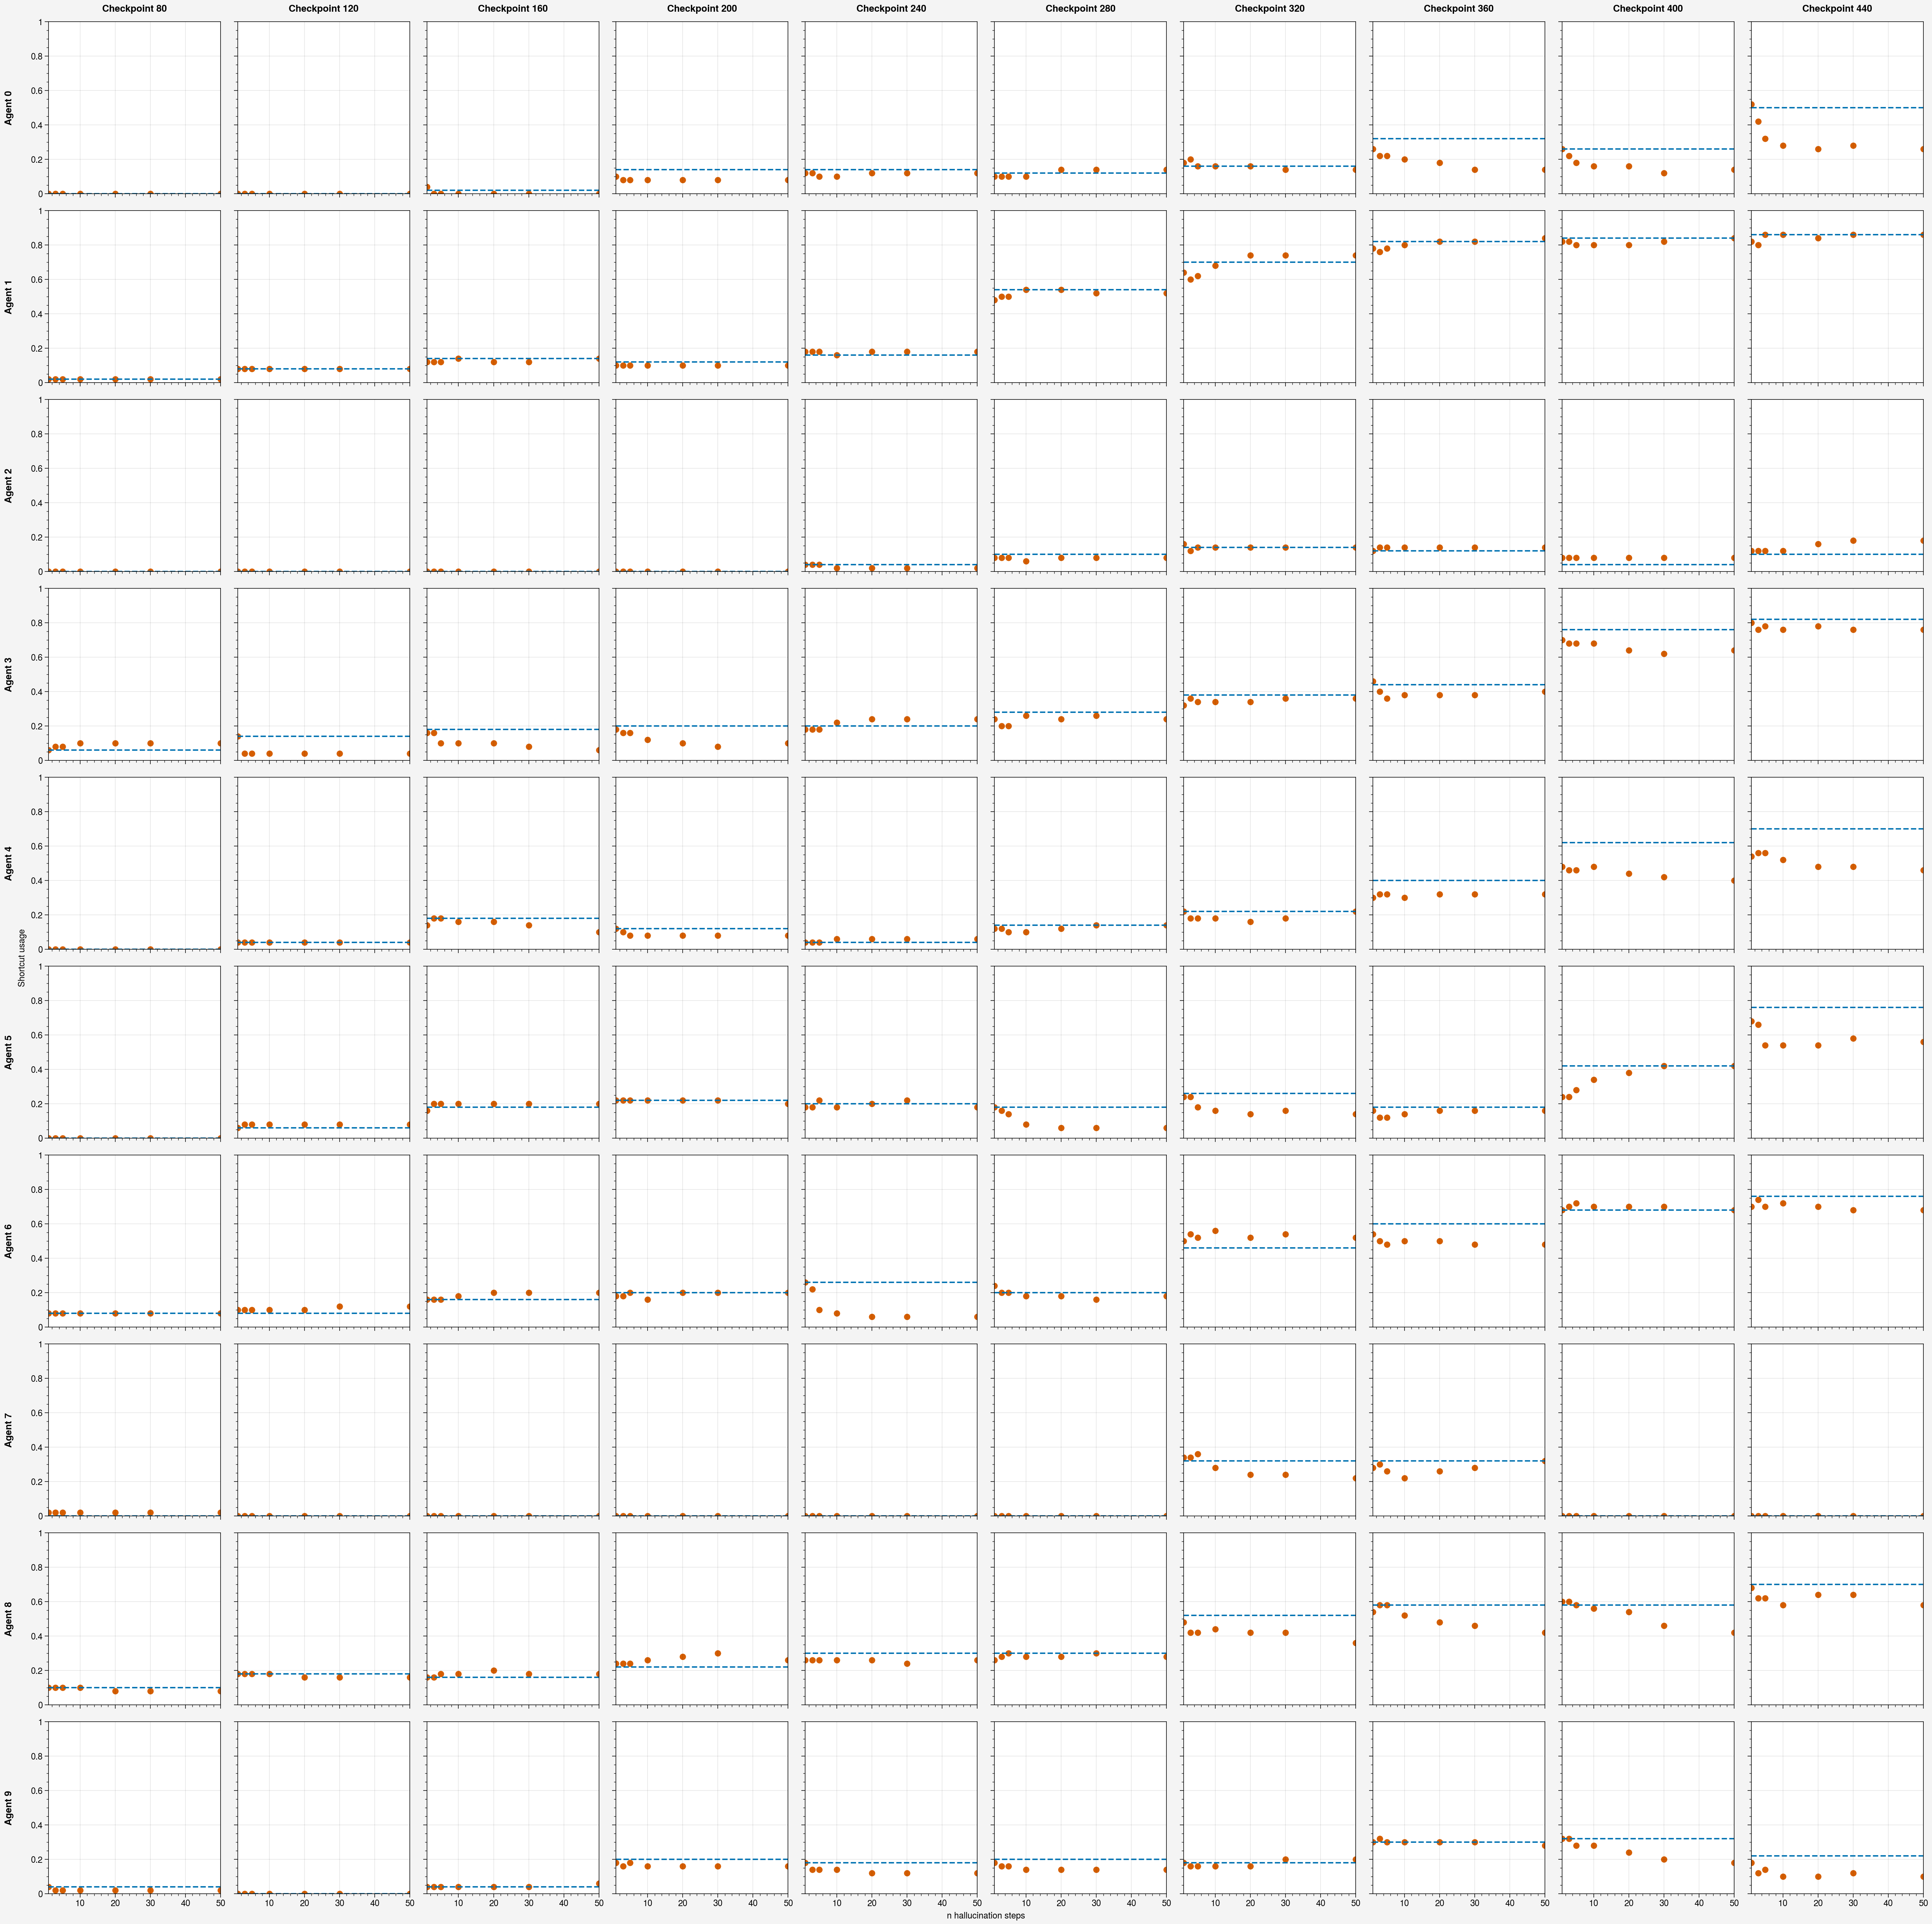

In [236]:
ns = all_res['ns']

fig, ax = pplt.subplots(nrows=10, ncols=10)
for i, t in enumerate(trials):
    for j in range(10):
        control = all_res[f'0.4_{t}']['control_uses']
        n_uses = all_res[f'0.4_{t}']['chk_n_uses']
        ax[i, j].plot([1, 50], [control[j]/50, control[j]/50], '--', label='Control')
        ax[i, j].scatter(ns, np.array(n_uses[j])/50, label='With hallucination')

ax.format(toplabels=[f'Checkpoint {chk}' for chk in chks[1:]], xlabel='n hallucination steps',
          leftlabels=[f'Agent {t}' for t in range(10)],
         ylabel='Shortcut usage', ylim=[0, 1])


# Constructed Trajectories experiment

Idea is to create trajectories where

a. agent goes straight to entrance without sighting the shortcut

b. add 2 steps where the shortcut is sighted, but otherwise the same

c. the same things but the step after sighting the agent stops moving